In [1]:
import os
import pydicom
from pprint import pprint

# Directory containing MRI studies
mri_data_root = "/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/"

In [2]:
from dicom_visitors import *

In [3]:
## Compare DICOM files listed in DICOMDIR to those available in subfolders

list_of_dicom_dir_files = []
list_of_dicom_dir_series = []
list_of_dicom_dir_studies = []
list_of_dicom_dir_patients = []
def list_of_dicom_dir_files_append(image_filename, dcm_image, dcmdir_entry):
    list_of_dicom_dir_files.append(image_filename) 
    list_of_dicom_dir_series.append(dcmdir_entry['series'].SeriesInstanceUID)
    list_of_dicom_dir_studies.append(dcmdir_entry['study'].StudyInstanceUID)
    list_of_dicom_dir_patients.append(dcmdir_entry['patient'].PatientID)
    
list_of_dicom_files = []
list_of_dicom_series = []
list_of_dicom_studies = []
list_of_dicom_patients = []
def list_of_dicom_files_append(image_filename, dcm_image):
    list_of_dicom_files.append(image_filename)
    list_of_dicom_series.append(dcm_image.SeriesInstanceUID)
    list_of_dicom_studies.append(dcm_image.StudyInstanceUID)
    list_of_dicom_patients.append(dcm_image.PatientID)
    
def validate_dicom_dir_collection(mri_data_root, max_dirs=2):
    mri_data_collection = sorted([s.path for s in os.scandir(mri_data_root) if s.is_dir()], key=lambda x: int(os.path.basename(x)))
    
    for mri_data_sample in mri_data_collection if max_dirs is None else mri_data_collection[:max_dirs]:
        # fetch the path to the test data
        mri_data_path = os.path.join(mri_data_root, mri_data_sample)
        
        visit_dicom_files(mri_data_path, list_of_dicom_files_append)
        
        filepath = os.path.join(mri_data_path, 'DICOMDIR')
        print('Validating DICOMDIR for {}...'.format(mri_data_path))
        dicom_dir = pydicom.filereader.read_dicomdir(filepath)
        base_dir = os.path.dirname(filepath)

        visit_dicom_dir(base_dir, dicom_dir, list_of_dicom_dir_files_append)
        
        for entity, list_dicom_files, list_dicom_dir in [('files',    list_of_dicom_files,    list_of_dicom_dir_files), 
                                                         ('series',   list_of_dicom_series,   list_of_dicom_dir_series),
                                                         ('studies',  list_of_dicom_studies,  list_of_dicom_dir_studies),
                                                         ('patients', list_of_dicom_patients, list_of_dicom_dir_patients)]:
            set_dicom_files = set(list_dicom_files)
            set_dicom_dir = set(list_dicom_dir)
            diff_files_to_dicom = set_dicom_files.difference(set_dicom_dir)

            if len(diff_files_to_dicom) > 0:
                diff_files_to_dicom_list = sorted(list(diff_files_to_dicom))
                print(" " * 4 + "Found {} {} in DICOMDIR and {} on filesystem. Only on filesystem:".format(len(set_dicom_dir), entity, len(set_dicom_files)))
                pprint(diff_files_to_dicom_list if len(diff_files_to_dicom_list) < 10 else diff_files_to_dicom_list[:10], indent=4)


            list_dicom_files.clear()
            list_dicom_dir.clear()
        
validate_dicom_dir_collection(mri_data_root)

Validating DICOMDIR for /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3...
Patient: ANONYM-REVX4: Anonymous3^Patient
    Study : 20090323
        Series 10: MR: N/A (2070 images)
            Reading images...
        Series 11: MR: N/A (690 images)
            Reading images...
    Found 2760 files in DICOMDIR and 5572 on filesystem. Only on filesystem:
[   '/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten '
    'Bern/3/10000000/10000001/10000002/10000003',
    '/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten '
    'Bern/3/10000000/10000001/10000002/10000004',
    '/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten '
    'Bern/3/10000000/10000001/10000002/10000005',
    '/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten '
    'Bern/3/10000000/10000001/10000002/10000006',
    '/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten '
    'Bern/3/10000000/100

In [4]:
# Compute value range of selected DICOM header fields based on images referenced in DICOMDIR files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image, dcmdir_entry):
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcmdir_entry[dcm_type], group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_dir_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)


Visiting /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3...
Patient: ANONYM-REVX4: Anonymous3^Patient
    Study : 20090323
        Series 10: MR: N/A (2070 images)
            Reading images...
        Series 11: MR: N/A (690 images)
            Reading images...
('ImageOrientationPatient grouped by patient (PatientID -> '
 'ImageOrientationPatient):')
{           'ANONYM-REVX4': {           (           "0.3436597181137",
                                                    "0.93909424348465",
                                                    "0.0",
                                                    "0.0",
                                                    "0.0",
                                                    "-1.0")}}
('ImageOrientationPatient grouped by study (StudyInstanceUID -> '
 'ImageOrientationPatient):')
{           '1.2.40.0.13.1.237828120959059386345548749032058253715': {           (           "0.3436597181137",
                         

In [5]:
# Compute value range of selected DICOM header fields based on all DICOM files

accumulate_attributes = ['ImageOrientationPatient', 'ImagePositionPatient'] #['MRAcquisitionType', 'ImageType', 'Modality'] # 'CardiacNumberOfImages', 'PatientAge'

accumulators = {accumulate_attribute: (('patient', {}), 
                                       ('study', {}), 
                                       ('series', {})) for accumulate_attribute in accumulate_attributes}
group_by = {'patient': 'PatientID', 
            'study': 'StudyInstanceUID', 
            'series': 'SeriesInstanceUID'}

def accumulate_visitor(image_filename, dcm_image):
    # Apply filter
    if not(dcm_image.MRAcquisitionType == '3D' and \
                ('M' in dcm_image.ImageType or 'P' in dcm_image.ImageType) and \
                dcm_image.Modality == 'MR'):
        print(" " * 4 + "Skipping {} due to lack of phase/magnitude image type".format(image_filename))# TODO: print range of headers of excluded images
    for accumulate_attribute in accumulate_attributes:
        for dcm_type, accumulator in accumulators[accumulate_attribute]: #[('patient', accumulate_by_patient), ('study', accumulate_by_study), ('series',accumulate_by_series)]:
            key = getattr(dcm_image, group_by[dcm_type])
            attribute = getattr(dcm_image, accumulate_attribute)
            if type(attribute) in [list, pydicom.multival.MultiValue]:
                attribute = tuple(attribute)
            if key in accumulator:
                accumulator[key].add(attribute)
            else:
                accumulator[key] = set([attribute])
            #print("{}: {}".format(image_filename, dcm_image.CardiacNumberOfImages))
    
#visit_dicom_dir(base_dir, dicom_dir, accumulate_visitor)
visit_dicom_file_collection(mri_data_root, accumulate_visitor, max_dirs=1)

for accumulate_attribute in accumulate_attributes:
    for dcm_type, accumulator in accumulators[accumulate_attribute]:
        pprint("{} grouped by {} ({} -> {}):".format(accumulate_attribute, dcm_type, group_by[dcm_type], accumulate_attribute), indent=12)
        pprint(accumulator, indent=12)
    pprint("{} aggregated for all patients:".format(accumulate_attribute), indent=12)
    accumulated_attribute_set = set()
    for attribute_set in accumulators[accumulate_attribute][0][1].values():
        accumulated_attribute_set = accumulated_attribute_set.union(attribute_set)
    pprint(accumulated_attribute_set, indent=12)

    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/100050D4 due to lack of phase/magnitude image type
    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/1000196A due to lack of phase/magnitude image type
    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/1000061D due to lack of phase/magnitude image type
    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/10000CC7 due to lack of phase/magnitude image type
    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/10005339 due to lack of phase/magnitude image type
    Skipping /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/10000000/10000001/10000013/10000715 due to lack of phase/magnitu

In [6]:
# Data exploration

mri_sample = "3"
mri_data_path = os.path.join(mri_data_root, mri_sample)

In [7]:
%%bash -s "$mri_data_path"
tree --filelimit 10 "$1"

/home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3
├── 10000000
│   └── 10000001
│       ├── 10000002 [2070 entries exceeds filelimit, not opening dir]
│       ├── 10000007 [690 entries exceeds filelimit, not opening dir]
│       ├── 10000013 [51 entries exceeds filelimit, not opening dir]
│       └── 100017F5
│           └── 100017F6
├── 1001A34A
│   └── 1001A34B
│       ├── 1001A34C [2070 entries exceeds filelimit, not opening dir]
│       └── 10030217 [690 entries exceeds filelimit, not opening dir]
└── DICOMDIR

10 directories, 2 files


In [8]:
## https://pydicom.github.io/pydicom/stable/auto_examples/input_output/plot_read_dicom_directory.html#sphx-glr-auto-examples-input-output-plot-read-dicom-directory-py

# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

# fetch the path to the test data
filepath = os.path.join(mri_data_path, 'DICOMDIR')
print('Path to the DICOM directory: {}'.format(filepath))
# load the data
dicom_dir = pydicom.filereader.read_dicomdir(filepath)
base_dir = os.path.dirname(filepath)

Path to the DICOM directory: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/DICOMDIR


In [9]:
## Overview of header fields
print("*** DICOMDIR ***")
pprint(dicom_dir)

*** DICOMDIR ***
{(0004, 1130): (0004, 1130) File-set ID                         CS: '1',
 (0004, 1200): (0004, 1200) Offset of the First Directory Recor UL: 374,
 (0004, 1202): (0004, 1202) Offset of the Last Directory Record UL: 374,
 (0004, 1212): (0004, 1212) File-set Consistency Flag           US: 0,
 (0004, 1220): <Sequence, length 2764>}


In [10]:
patient_record = dicom_dir.patient_records[0]
print("*** PATIENT ***")
pprint(patient_record)

*** PATIENT ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 504,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'PATIENT',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0010, 0010): (0010, 0010) Patient's Name                      PN: 'Anonymous3^Patient',
 (0010, 0020): (0010, 0020) Patient ID                          LO: 'ANONYM-REVX4'}


In [11]:
study = patient_record.children[0]
print("*** STUDY ***")
pprint(study)

*** STUDY ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 0,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 708,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'STUDY',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0030): (0008, 0030) Study Time                          TM: '162952.234',
 (0008, 0050): (0008, 0050) Accession Number                    SH: 'XIYJUKXLJH',
 (0020, 000d): (0020, 000d) Study Instance UID                  UI: 1.2.40.0.13.1.237828120959059386345548749032058253715,
 (0020, 0010): (0020, 0010) Study ID                            SH: ''}


In [12]:
series = study.children[0]
print("*** SERIES ***")
pprint(series)

*** SERIES ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1757982,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 904,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'SERIES',
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0031): (0008, 0031) Series Time                         TM: '171351.031',
 (0008, 0060): (0008, 0060) Modality                            CS: 'MR',
 (0020, 000e): (0020, 000e) Series Instance UID                 UI: 1.2.40.0.13.1.25036309036536625224276724877695836772,
 (0020, 0011): (0020, 0011) Series Number                       IS: "10"}


In [13]:
image_record = series.children[0]
print("*** IMAGE ***")
#pprint(dir(image_record))
pprint(image_record)

*** IMAGE ***
{(0004, 1400): (0004, 1400) Offset of the Next Directory Record UL: 1752,
 (0004, 1410): (0004, 1410) Record In-use Flag                  US: 65535,
 (0004, 1420): (0004, 1420) Offset of Referenced Lower-Level Di UL: 0,
 (0004, 1430): (0004, 1430) Directory Record Type               CS: 'IMAGE',
 (0004, 1500): (0004, 1500) Referenced File ID                  CS: ['1001A34A', '1001A34B', '1001A34C', '1001A34D'],
 (0004, 1510): (0004, 1510) Referenced SOP Class UID in File    UI: MR Image Storage,
 (0004, 1511): (0004, 1511) Referenced SOP Instance UID in File UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0004, 1512): (0004, 1512) Referenced Transfer Syntax UID in F UI: Implicit VR Little Endian,
 (0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0032): (0008, 0032) Acquisition Time                    TM: '165409.150',
 (0008, 1140): <Sequenc

*** SINGLE IMAGE FILE ***
Image filename: /home/lukasd/src/hpc-predict/data/v0/input_data/original/mri/MRT Daten Bern/3/1001A34A/1001A34B/1001A34C/1001A34D
{(0008, 0005): (0008, 0005) Specific Character Set              CS: 'ISO_IR 100',
 (0008, 0008): (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'P', 'DIS2D'],
 (0008, 0012): (0008, 0012) Instance Creation Date              DA: '20090323',
 (0008, 0013): (0008, 0013) Instance Creation Time              TM: '171419.671',
 (0008, 0016): (0008, 0016) SOP Class UID                       UI: MR Image Storage,
 (0008, 0018): (0008, 0018) SOP Instance UID                    UI: 1.2.40.0.13.1.214339010389129923903255300662291473381,
 (0008, 0020): (0008, 0020) Study Date                          DA: '20090323',
 (0008, 0021): (0008, 0021) Series Date                         DA: '20090323',
 (0008, 0022): (0008, 0022) Acquisition Date                    DA: '20090323',
 (0008, 0023): (0008, 0023) Content Date    

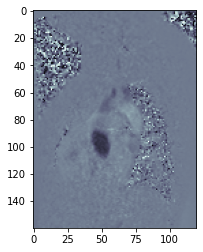

In [14]:
# DICOM tags can be checked here:
# https://www.dicomstandard.org/current
# e.g. in http://dicom.nema.org/medical/dicom/current/output/html/part03.html

image_filename = os.path.join(base_dir, *image_record.ReferencedFileID)
dicom_img = pydicom.dcmread(image_filename)
print("*** SINGLE IMAGE FILE ***")
print("Image filename: {}".format(image_filename))
pprint(dicom_img)
import matplotlib.pyplot as plt
plt.imshow(dicom_img.pixel_array, cmap=plt.cm.get_cmap('bone'))
plt.show()

In [15]:
# # go through the patient record and print information
# for patient_record in dicom_dir.patient_records:
#     if (hasattr(patient_record, 'PatientID') and
#             hasattr(patient_record, 'PatientName')):
#         print("Patient: {}: {}".format(patient_record.PatientID,
#                                        patient_record.PatientName))
#     studies = patient_record.children
#     # go through each series
#     for study in studies:
#         print(" " * 4 + "Study {}: {}".format(study.StudyID,
#                                                   study.StudyDate))
#         all_series = study.children
#         # go through each serie
#         for series in all_series:
#             image_count = len(series.children)
#             plural = ('', 's')[image_count > 1]

#             # Write basic series info and image count

#             # Put N/A in if no Series Description
#             if 'SeriesDescription' not in series:
#                 series.SeriesDescription = "N/A"
#             print(" " * 8 + "Series {}: {}: {} ({} image{})".format(
#                 series.SeriesNumber, series.Modality, series.SeriesDescription,
#                 image_count, plural))

#             # Open and read something from each image, for demonstration
#             # purposes. For simple quick overview of DICOMDIR, leave the
#             # following out
#             print(" " * 12 + "Reading images...")
#             image_records = series.children
#             image_filenames = [os.path.join(base_dir, *image_rec.ReferencedFileID)
#                                for image_rec in image_records]

#             datasets = [pydicom.dcmread(image_filename)
#                         for image_filename in image_filenames]

#             patient_names = set(ds.PatientName for ds in datasets)
#             patient_IDs = set(ds.PatientID for ds in datasets)

#             # Extract some more fields from headers of DICOM images
            
#             # List the image filenames
#             print("\n" + " " * 12 + "Image filenames:")
#             print(" " * 12, end=' ')
#             pprint(image_filenames, indent=12)

#             # Expect all images to have same patient name, id
#             # Show the set of all names, IDs found (should each have one)
#             print(" " * 12 + "Patient Names in images..: {}".format(
#                 patient_names))
#             print(" " * 12 + "Patient IDs in images..: {}".format(
#                 patient_IDs))